In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cpu


## Data

In [5]:
weight = 0.7
bias = 0.3

# Create range of values
start = 0
end = 1
step = 0.02

# Create X and y (feature and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [8]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test),  len(y_test)

(40, 40, 10, 10)

## Visualize the data

In [9]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  """
  Plots training data, test data and compares predictions.
  """

  plt.figure(figsize=(6,4))
  # Plot the training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

  # Plot the test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Test Data")

  # Are there predictions?
  if predictions is not None:
    # Plot prediction
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})


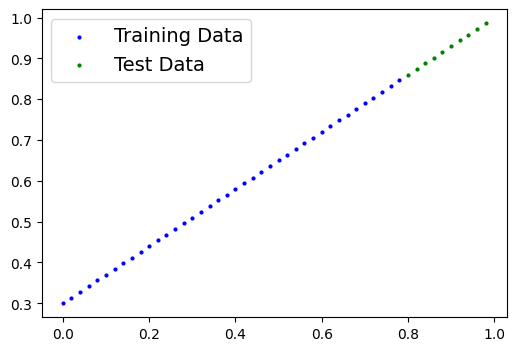

In [10]:
plot_predictions()

## Build the model

In [13]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# set manual seed
torch.manual_seed(42)
model = LinearRegressionModel()
model, model.state_dict()



(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [14]:
# Check the model current device
next(model.parameters()).device

device(type='cpu')

In [15]:
# Set the model to use the target device
model.to(device)
next(model.parameters()).device

device(type='cpu')

## Training

For training we need:
* Loss function
* Optimizer
* Training Loop
* Testing Loop

In [17]:
loss_fn = nn.L1Loss() # or MAE
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01) # STOCHASTIC GRADIENT DESCENT

In [21]:
# Traning Loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
for epoch in range(epochs):
  model.train()

  # 1. Forward pass
  y_pred = model(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Back propagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146 | Test Loss: 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878 | Test Loss: 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504 | Test Loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765 | Test Loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test Loss: 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035 | Test Loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215679459273815 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.002787243574857712 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.01380180753767

In [22]:
print(model.state_dict())

OrderedDict([('linear_layer.weight', tensor([[0.6968]])), ('linear_layer.bias', tensor([0.3025]))])


## Making and evaluating predictions




In [24]:
# Turn model into evaluation mode
model.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_pred = model(X_test)

y_pred

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

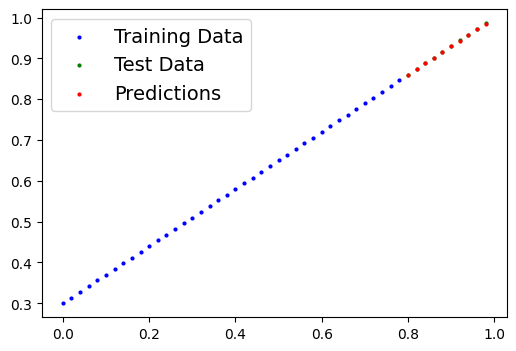

In [26]:
plot_predictions(predictions=y_pred.cpu())

## Saving & Loading the model

In [29]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model.pth


In [30]:
# Load a PyTorch model

# Create a new instance of linear regression model
loaded_model = LinearRegressionModel()

# Load the saved model state_dict
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [31]:
next(loaded_model.parameters()).device

device(type='cpu')

In [32]:
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [34]:
# Evaluate loaded model
loaded_model.eval()

with torch.inference_mode():
  loaded_model_pred = loaded_model(X_test)

y_pred == loaded_model_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])